In [22]:
using DataFrames, CSV
using JuMP, Gurobi
using LinearAlgebra, Random, Printf
using Plots

const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-07-08


Gurobi.Env(Ptr{Nothing} @0x00007f867c9e1400, false, 0)

In [102]:
arcs = CSV.read("Pb1_arcs.csv", DataFrame)
transport = CSV.read("Pb1_transport.csv", DataFrame)
demand = CSV.read("Pb1_demand.csv", DataFrame)
customers = CSV.read("Pb1_customer_OD.csv", DataFrame)
arcs_ = convert.(Int64,arcs[!,2:3])

,x2,x3
,Int64,Int64
1,2,1
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,1


In [17]:
customers

,x1,x2
,Int64,Int64
1,1,9
2,4,2
3,8,2


## 1. Problem setup

In [107]:
TIME_LIMIT = 90;
OPTIMALITY_GAP = 0.001;

"Solve problem using multi-cut Benders decomposition"
function solve_benders_multi(verbose::Bool=true)
    # define main problem
    MP = Model(() -> Gurobi.Optimizer(GRB_ENV));
    set_optimizer_attributes(MP, "TimeLimit" => 60, "MIPGap" => 1e-4, "OutputFlag" => 0, "DualReductions" => 0)
    A = size(arcs, 1); K = size(customers, 1); S = size(demand, 2)
    @variable(MP, x[1:A], Bin)
    @variable(MP, θ[1:S] >= 0)
    @objective(MP, Min, sum(arcs[i,5] * x[i] for i=1:A) + sum(1/S * θ[s] for s in 1:S))
    lower_bound_all = []; upper_bound_all = []
    MP_time = []; SP_max_time = []; SP_time = []
    num_opt = 0; num_feas = 0
    while true
        # solve master problem
        push!(MP_time, @elapsed optimize!(MP))
        lower_bound_new = objective_value(MP)
        push!(lower_bound_all, lower_bound_new)
        x_MP = value.(MP[:x])
        # solve S subproblems
        obj_SP = zeros(S) 
        SP_time_all = zeros(S)
        for s = 1:S
            
            SP_dual = Model(JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), 
                "OutputFlag" => 0, "DualReductions" => 0, "TimeLimit" => 60))
            
            @variable(SP_dual, λ[1:10,1:K]);
            @variable(SP_dual, μ[1:A] <= 0);
            
            @objective(SP_dual, Max,
                       sum((λ[customers[k,1],k]-λ[customers[k,2],k]) * demand[k,s] for k in 1:K) +
                       sum(μ[i] * arcs[i,4] * x_MP[i] for i in 1:A))
            
            @constraint(SP_dual, [i in 1:A, k in 1:K], 
                λ[arcs_[i,1],k] - λ[arcs_[i,2],k] + μ[i] <= transport[i,k])

            SP_time_all[s] = @elapsed optimize!(SP_dual)
            #obj_SP_dual = objective_value(SP_dual)
            λ_val = value.(SP_dual[:λ])
            μ_val = value.(SP_dual[:μ])            
            if termination_status(SP_dual) == MOI.DUAL_INFEASIBLE # feasibility cut
                @constraint(MP, sum((λ_val[customers[k,1],k]-λ_val[customers[k,2],k]) * demand[k,s] for k in 1:K) +
                       sum(μ_val[i] * arcs[i,4] * x[i] for i in 1:A) <= 0) 
                obj_SP[s] = 3200
                num_feas += 1
            elseif termination_status(SP_dual) == MOI.OPTIMAL
                @constraint(MP, θ[s] >= sum((λ_val[customers[k,1],k]-λ_val[customers[k,2],k]) * demand[k,s] for k in 1:K) +
                       sum(μ_val[i] * arcs[i,4] * x[i] for i in 1:A))
                obj_SP[s] = objective_value(SP_dual)
                num_opt += 1
            end
        end
        push!(SP_max_time, maximum(SP_time_all))
        push!(SP_time, sum(SP_time_all))
        upper_bound_new = sum(arcs[i,5] * x_MP[i] for i=1:A) + sum(1/S * obj_SP[s] for s in 1:S)
        push!(upper_bound_all, upper_bound_new)
        verbose && @printf("UB: %.2f - LB: %.2f\n", upper_bound_all[end], lower_bound_all[end])
        if sum(MP_time) + sum(SP_time) >= TIME_LIMIT ||
            (upper_bound_new-lower_bound_new)/lower_bound_new < OPTIMALITY_GAP
            break
        end
    end
    return upper_bound_all, lower_bound_all, MP_time, SP_time, SP_max_time, num_feas, num_opt
end

solve_benders_multi

In [108]:
upper_bound_all, lower_bound_all, MP_time, SP_time, SP_max_time, num_feas, num_opt = solve_benders_multi()

UB: 3200.00 - LB: 0.00
UB: 3210.05 - LB: 10.05
UB: 3210.55 - LB: 10.55
UB: 3210.56 - LB: 10.56
UB: 3212.90 - LB: 12.90
UB: 3220.11 - LB: 20.11
UB: 3220.74 - LB: 20.74
UB: 3220.81 - LB: 20.81
UB: 3221.25 - LB: 21.25
UB: 3224.19 - LB: 24.19
UB: 3230.80 - LB: 30.80
UB: 3231.69 - LB: 31.69
UB: 3232.80 - LB: 32.80
UB: 3233.77 - LB: 33.77
UB: 3352.03 - LB: 34.25
UB: 3234.29 - LB: 34.29
UB: 3234.74 - LB: 34.74
UB: 2743.14 - LB: 34.75
UB: 3365.28 - LB: 2152.35
UB: 2756.38 - LB: 2152.85
UB: 2743.14 - LB: 2743.14


(Any[3200.0, 3210.054529448178, 3210.5504810699804, 3210.562429355936, 3212.898361166845, 3220.1136273655734, 3220.742821014491, 3220.807068585424, 3221.2507209222485, 3224.190843426695  …  3231.6882584851733, 3232.8006372684135, 3233.773629273072, 3352.0328794045035, 3234.286055186306, 3234.7413244966756, 2743.136793777782, 3365.27728915555, 2756.381203528829, 2743.136793777782], Any[0.0, 10.054529448177977, 10.550481069980382, 10.5624293559357, 12.89836116684521, 20.113627365573514, 20.742821014490755, 20.80706858542427, 21.250720922248476, 24.19084342669534  …  31.688258485173435, 32.80063726841344, 33.77362927307213, 34.24994134409088, 34.28605518630586, 34.74132449667572, 34.75327278263104, 2152.350838312871, 2152.854169751412, 2743.1367937777823], Any[0.001021085, 0.002473057, 0.000699174, 0.001314428, 0.001464564, 0.005083717, 0.00157934, 0.002331034, 0.001769716, 0.002026514  …  0.002012163, 0.002877235, 0.006162246, 0.003313874, 0.002469903, 0.002317671, 0.002410215, 0.0025128

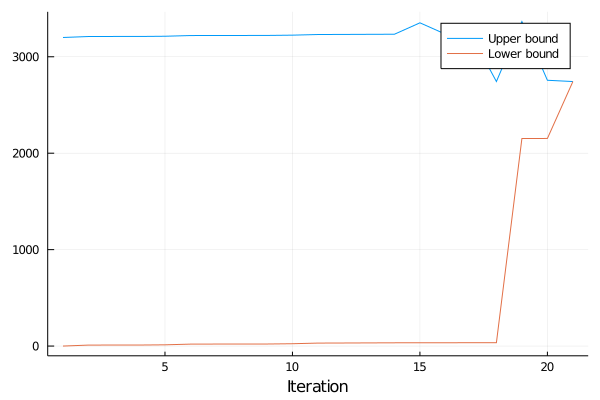

In [109]:
plot([upper_bound_all lower_bound_all], label=["Upper bound" "Lower bound"], xlabel="Iteration")

In [106]:
@show length(upper_bound_all)
@show num_opt 
@show num_feas

length(upper_bound_all) = 21
num_opt = 10
num_feas = 32


32